# Nansen Legacy stations - ice covered days

**Adam Steer**

**November 2022**

In the Nansey Legacy project, 42 locations were picked for repeat sampling of ocean and other parameters. Some of these sites were in open water for most of the year, some were ice covered between November and June each year. This notebook uses  University of Bremen daily sea ice concentration products to estimate the presence, absence, and concentration of ice areound Nansen Legacy sampling sites. 

### Analytical method

Picking values from sea ice concentration maps using a buffered point

### Work in progress

- add real station locations from ship logs, rather than planning documents
- add a method for visualising when a station was occupied

### Datasets

Nansen legacy station locations: https://github.com/SIOS-Svalbard/AeN_data


#### Sea ice concentration
University of Bremen sea ice concentration: https://seaice.uni-bremen.de/sea-ice-concentration/amsre-amsr2/information/

These are a 6.25 km resolution gridded product based on AMSR-E and AMSR2 passive microwave sensors.

To obtain a whole year of data it is probably easiest to head here: https://seaice.uni-bremen.de/data/amsr2/asi_daygrid_swath/n6250/netcdf/ and download a yearly zip file.

The page here: https://seaice.uni-bremen.de/data-archive/ gives detailed instructions on how to programatically download files using `wget`and other methods.

**Why this dataset?** It is detailed enough that maps look more like what we see from a ship in the ice than, say, an SSMI based sea ice concentration estimate. It also fit for useability (pretty easy), and more detail about validation studies than some other sources.


### Running this code on your own

This notebook was set up and built using miniconda: https://docs.conda.io/en/latest/miniconda.html

Please read the documentation about building and using virtual environments.

The virtual environment used for this noteboook can be built as follows:

`conda create -n env_name -c conda-forge datetime json glob os matplotlib numpy scipy pylab pyproj shapely ogr pandas cartopy geojson rioxarray`

There is no need to hardcode package versions - this notebook tries to avoid analytical methods which might be version-breakable.

Various data structures are used - lists, numpy arrays, dictionaries, Pandas dataframes. Each has their own purpose, if you see  a better way to do things pull requests are welcome!

### Setting up

Importing all the python libraries we need here.

In [2]:
## import all the libraries

# standard library stuff

import datetime
import json
import glob
import os

# matplotlib stuff

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pylab as pl
import numpy as np

# a cell magick to show plots in the notebook
%matplotlib inline

# things we need from Pyproj. Review once we're closer to final
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
from pyproj import transformer as transformer

# shapely. Review this list at the end, we may not need all of this

from shapely.geometry import Point, LineString, Polygon, shape, GeometryCollection, mapping
import shapely.wkt
from shapely.ops import transform

#OGR, for shapefile reading.
from osgeo import ogr

#Pandas for doing data table manipulation, also for easy IO
import pandas as pd

#geojson

import geojson

#xarray parts for netcdf wrangling

import xarray,rioxarray

In [3]:
# Cartopy parts for map building
import cartopy.crs as ccrs
import cartopy.feature as cfeat

import cartopy.feature as cfeature
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])


import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

### Setting up standaed Nansen Legacy sampling locations

Standard Nansen Legacy sampling locations are stored in a GeoJSON file as a latitude, longitude and station label. The GeoJSON file is imported and converted to a shapely geometry. Every NLEG and P station is included in the GeoJSON file. The GeoJSON file should be kept in the same repository as this notebook. 

In [ ]:
# import the file into a JSON dictionary

with open("../mapdata/NansenLegacyStations-sorted.geojson") as f:
    nleg_stations = json.load(f)["features"]

In [ ]:
# show what each feature looks like
nleg_stations

In [ ]:
len(nleg_stations)

In [ ]:
# build a list of station names, this is used later to make a Pandas dataframe index later.
# this one-liner is a python list comprehension - a shorthand way of writing 'for' loops.

station_index = [station["properties"]["stationName"] for station in nleg_stations]

### Reprojecting and buffering points

Having a set of longitudes and latitudes is less great for analytical work, and working in metres or kilometers is a bit better. So we first want to reproject the coordinates to a system expressed in meters, and then apply a buffer to each point in meters. This is done using the Python API to Proj6 [https://proj.org]

Proj strings for projections being used are:

NSIDC North Polar Stereographic (EPSG:3413): `+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs `

WGS84 lat / lon (EPSG:4326): `+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs`

Sampling station points are buffered to collect a small set of ice concentration values, aiming to make the estimate for each site and day a little more robust. In thise notebook, 5000 meters is used. This makes a circle of 5000 meter radius around each point. Sea ice concentration pixels falling within that circle are used to compute a value for the site.

### to do

- reconfigure this process to use different sets of positions for each year instead of using a list of fixed locations

In [ ]:
#set up a PyProj transformer
nleg_transformer = transformer.Transformer.from_crs(4326,
                                                "+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [ ]:
#get our feature of interest and transform it. P7 is a nice one to play with..
# found by iterating manually through the dictionary to the right element

nleg_stations[24]["properties"]["stationName"]

In [ ]:
# check the geometery of what we hope is P7, to see its coordinates
nleg_stations[24]["geometry"]

In [29]:
#transform the P7 point from lon / lat to NSIDC north polar stero

p7northpolar = nleg_transformer.transform(nleg_stations[24]["geometry"]["coordinates"][1],
                                      nleg_stations[24]["geometry"]["coordinates"][0])
p7northpolar

(862592.5516443305, -216914.76587085257)

In [30]:
#make a point geometry in NSIDC North Polar Stereo
p7point = Point(p7northpolar[0], p7northpolar[1])
print(mapping(p7point))

{'type': 'Point', 'coordinates': (862592.5516443305, -216914.76587085257)}


In [31]:
#buffer the point by 5000 meters - this gives a circular region with radius 5000 m, diameter 10000 m

p7dot = p7point.buffer(5000)

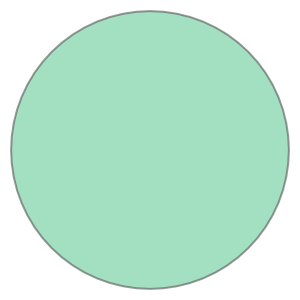

In [32]:
p7dot

In [33]:
# to see the dot geometry as GeoJSON, uncomment the next line and run this cell
#print(mapping(p7dot))

## testing sea ice concentration picking

Using the same days, extract median sea ice concentration inside the buffered point.

In [35]:
# get ice concentration from march 27, 2021

ice_concentration = "../../Documents/iceconc-bremen-daily/2021/asi-AMSR2-n6250-20210327-v5.4.nc"

In [36]:
#double checking our P7 dot location, note that these are XY coordinates in meters, using NSIDC North Polar Stereo
p7dot.centroid.coords.xy

(array('d', [862592.5516443307]), array('d', [-216914.76587085254]))

In [37]:
# open a single ice concentration dataset
dataset = rioxarray.open_rasterio(ice_concentration, masked=True)

In [38]:
# get a plain JSON representation of our p7 dot geometry
p7json = geojson.dumps(mapping(p7dot))

In [203]:
# show that the P7 dot actually overlaps some ice...

fig = plt.figure(figsize=(20,12))

ax = fig.add_subplot(111, 
                     projection=ccrs.NorthPolarStereo())

ax.set_extent((600000, 1500000, -450000, 50000), crs=ccrs.NorthPolarStereo())

# plot the sea ice concentration grid
dataset.plot(cmap="Blues_r")

# add the dot, make it red
ax.add_geometries([p7dot], edgecolor=[0.3, 0.3, 0.3], facecolor=[1,0,0,0.8],
                  crs=ccrs.NorthPolarStereo())

# draw latlon grid lines
mapgrid = ax.gridlines()

In [217]:
# Use rioxarray's clip method to get values of sea ice concentration pixels inside the buffered point

clipped = dataset.rio.clip([json.loads(p7json)], all_touched=True)

In [218]:
# inspect the values

clipped.values

array([[[86.226875, 93.35197 ],
        [85.98946 , 89.46493 ],
        [84.253174, 88.77065 ]]], dtype=float32)

In [221]:
np.median(clipped.values)

87.498764

OK! We can get a concentration number! Now we need to figure out netcdf date parsing...

In [220]:
ice_conc_file = os.path.basename(ice_concentration)

In [56]:
ice_conc_file

'asi-AMSR2-n6250-20210327-v5.4.nc'

In [57]:
ice_year = ice_conc_file[16:20]
ice_month = ice_conc_file[20:22]
ice_day = ice_conc_file[22:24]

print("Year: {}, Month: {}, Day: {}".format(ice_year, ice_month, ice_day))

Year: 2021, Month: 03, Day: 27


In [58]:
# using datetime, convert to a datestamp
ice_date = datetime.datetime(int(ice_year), int(ice_month), int(ice_day))

year = ice_date.year
month = ice_date.month
day = ice_date.day

print(day,month,year)

27 3 2021


#### Setting up a visualisation

It makes sense to make one histogram per year, and combine results for a multi-year look. This brings to mind a github style contribution graph, and a cool example is here: https://stackoverflow.com/questions/24163313/how-to-create-an-activity-plot-from-pandas-dataframe-like-the-github-contributi

It won't be an exact copy, because this dataset contains multiple stations - so the axis for 'weekday' in that example will show instead 'sampling station', and to start with the Y axis will be day of year.


A preparation step here is to make an index of station names. This is used later to reorganise data for plotting into a latitude based order. The station locations and names are imported in latitude order, however that gets lost in processing. It will become clear.

The function below was worked out cell by cell initially - great for one year, less great for a few years. See Appendix A in the notebook.

**inputs**
- a list of station geometries
- a directory of ice concentration files
- optionally a proj transformer object

**output**
- a set of python lists: station name, day of year, and ice concentration

In [228]:
def check_ice_cover(query_points, ice_concentration_folder, the_transformer=None):
    """
    Inputs:
    
    query_points - an array of one or more dictionaries which define point geometries, formatted like:
    
    [{'type': 'Feature',
      'properties': {'stationName': 'P1 (NLEG01)',
      'decimalLatitude': 76.0,
      'decimalLongitude': 31.22},
      'geometry': {'type': 'Point', 'coordinates': [31.22, 76.0]}} ]
    
    
    ice_concentration_folder - a folder containing one or more ice concentration grids in netCDF format
    
    
    Returns:
    station_names - a list of station names, repeated for every ice concentration file
    year days - a list of day-of-year numbers corresponding to the ice concentration files, repeated for every station name
    ice - a list of ice concentration values, one for each station for each day.
    
    Resulting lists are (N ice concentration files) * (N stations) long.
    """
    
    # set some empty lists up for later - these are filled and returned
    station_names = []
    year_days = []
    ice = []
    dataset = None
    
    print('Setting up ice concentration file lists')

    ice_concentration_names = []
    ice_concentration_dates = []
    for f in os.listdir(ice_concentration_folder):
        if f.endswith('.nc'):
            
            ice_concentration_names.append(f)
            ice_conc_file = os.path.basename(f)
            
            if ice_conc_file.startswith('asi-'):
                ice_year = ice_conc_file[16:20]
                ice_month = ice_conc_file[20:22]
                ice_day = ice_conc_file[22:24]
                ice_date = datetime.datetime(int(ice_year), int(ice_month), int(ice_day))
                
            if ice_conc_file.startswith('sic_modis'):
                ice_year = ice_conc_file[45:49]
                ice_month = ice_conc_file[49:51]
                ice_day = ice_conc_file[51:53]
                ice_date = datetime.datetime(int(ice_year), int(ice_month), int(ice_day))

            ice_concentration_dates.append(ice_date.timetuple().tm_yday)
    #print(ice_concentration_dates)
            
    print('Testing ice cover...')
    # Now iterate over query points      

    i = 0

    for the_conc in ice_concentration_names:
        #year_days.append(ice_concentration_dates[i])
        #print(ice_concentration_dates[i])
        #print(ice_concentration_names[the_conc])
        file_path = ice_concentration_folder + "/" + the_conc
        #print(file_path)
        dataset = rioxarray.open_rasterio(file_path, masked=True)

        #iterate over stations for that day
        for station in query_points:
            # get the station name and put it in a string
            station_name = station["properties"]["stationName"]
            #print(station_name)

            #get and transform the geometry
            northpolar_point = the_transformer.transform(station["geometry"]["coordinates"][1],
                                              station["geometry"]["coordinates"][0])

            station_latitude = station["geometry"]["coordinates"][1]
            
            #make the new point a shapely geometry and buffer it by 5000m
            station_point = Point(northpolar_point[0], northpolar_point[1])
            station_dot = station_point.buffer(5000)

            station_json = geojson.dumps(mapping(station_dot))
            
            #clip out all ice concentration pixels touched by the geometry
            clipped = dataset.rio.clip([json.loads(station_json)], all_touched=True)

            ice_result = np.nanmedian(clipped.values)/100
            if np.isnan(ice_result):
                ice_result = 0
            
            # put results to lists
            ice.append(ice_result)
            station_names.append(station_name)
            year_days.append(ice_concentration_dates[i])

        dataset.close()
 
        i += 1

    print("done")
    return station_names, year_days, ice

In [229]:
def make_dataframe(station_names, year_days, ice):
    
    df = pd.DataFrame(columns=["station", "yearday", "ice"])

    df["station"] = station_names
    df["yearday"] = year_days
    df["ice"] = ice
    df.dropna(inplace = True)

    return df

def pivot_data_frame(df, station_index=None):
    
    df = df.pivot(columns = "yearday", index="station", values = "ice")
    df = df.reindex(station_index)
    
    return df

In [230]:
def plot_df(df,year, cmap = None):
    
    station, yearday = np.mgrid[:df.shape[0]+1, :df.shape[1]+1]
    
    maxnumber = df.to_numpy().max()
    print(maxnumber)
    
    fig = plt.figure(figsize=(40, 8), dpi=300)
    #ax.set_aspect("equal")
    

    if cmap is not None:
        the_cmap = cm.get_cmap(cmap).copy()
    else:
        the_cmap = cm.get_cmap('Blues_r').copy()

    
    the_cmap.set_under([0.4,0.4,0.4])
    plt.pcolormesh(yearday, station, df.values, cmap=the_cmap, edgecolor="w", vmin=0.0000001, vmax=1)
    
    ax = plt.gca()
    
    plt.xlim(0, df.shape[1])
    
    #plt.yticks(tw17_2["station"])
    plt.yticks(range(len(df.index)))
    ax.set_yticklabels(df.index, va='bottom')
    ax.set_facecolor((1.0, 0.47, 0.42))
    
    cbar = plt.colorbar(fraction=0.1)
    
    #tick_locs = (np.arange(maxnumber+1) + 0.5)*(maxnumber)/maxnumber+1
    #cbar.set_ticks(tick_locs)
    
    plt.savefig('../../icedays-sic' + str(year) + '.png', bbox_inches='tight', dpi = (300))
    plt.savefig('../../icedays-sic' + str(year) + '.jpg', bbox_inches='tight', dpi = (300))

In [231]:
years = [2017, 2018, 2019, 2020, 2021]

In [232]:
concentration_root = "../../Documents/iceconc-bremen-daily/"

In [233]:
# iterate over years, make a dataframe and a plotting dataframe for each year, stash
# results in two dictionaries - one arrranged as a column of data, and the other gridded for
# a calendar plot

dataframes = {}
plot_data = {}
for year in years:
    print(year)   
    conc_folder = concentration_root + str(year) + "/"

    station_names, year_days, ice = check_ice_cover(nleg_stations, conc_folder, nleg_transformer)
    
    #print(year_days)
    #print(ice)
    #print(station_names)
    
    df = make_dataframe(station_names, year_days, ice)
    
    dataframes[str(year)] = df
    plot_data[str(year)] = pivot_data_frame(df, station_index)



2017
Setting up ice concentration file lists
Testing ice cover...


C:\Users\Adam.Steer\Miniconda3\envs\iceanalysis\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\Adam.Steer\Miniconda3\envs\iceanalysis\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\Adam.Steer\Miniconda3\envs\iceanalysis\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\Adam.Steer\Miniconda3\envs\iceanalysis\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\Adam.Steer\Miniconda3\envs\iceanalysis\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = fun

done
2018
Setting up ice concentration file lists
Testing ice cover...
done
2019
Setting up ice concentration file lists
Testing ice cover...
done
2020
Setting up ice concentration file lists
Testing ice cover...
done
2021
Setting up ice concentration file lists
Testing ice cover...
done


1.0


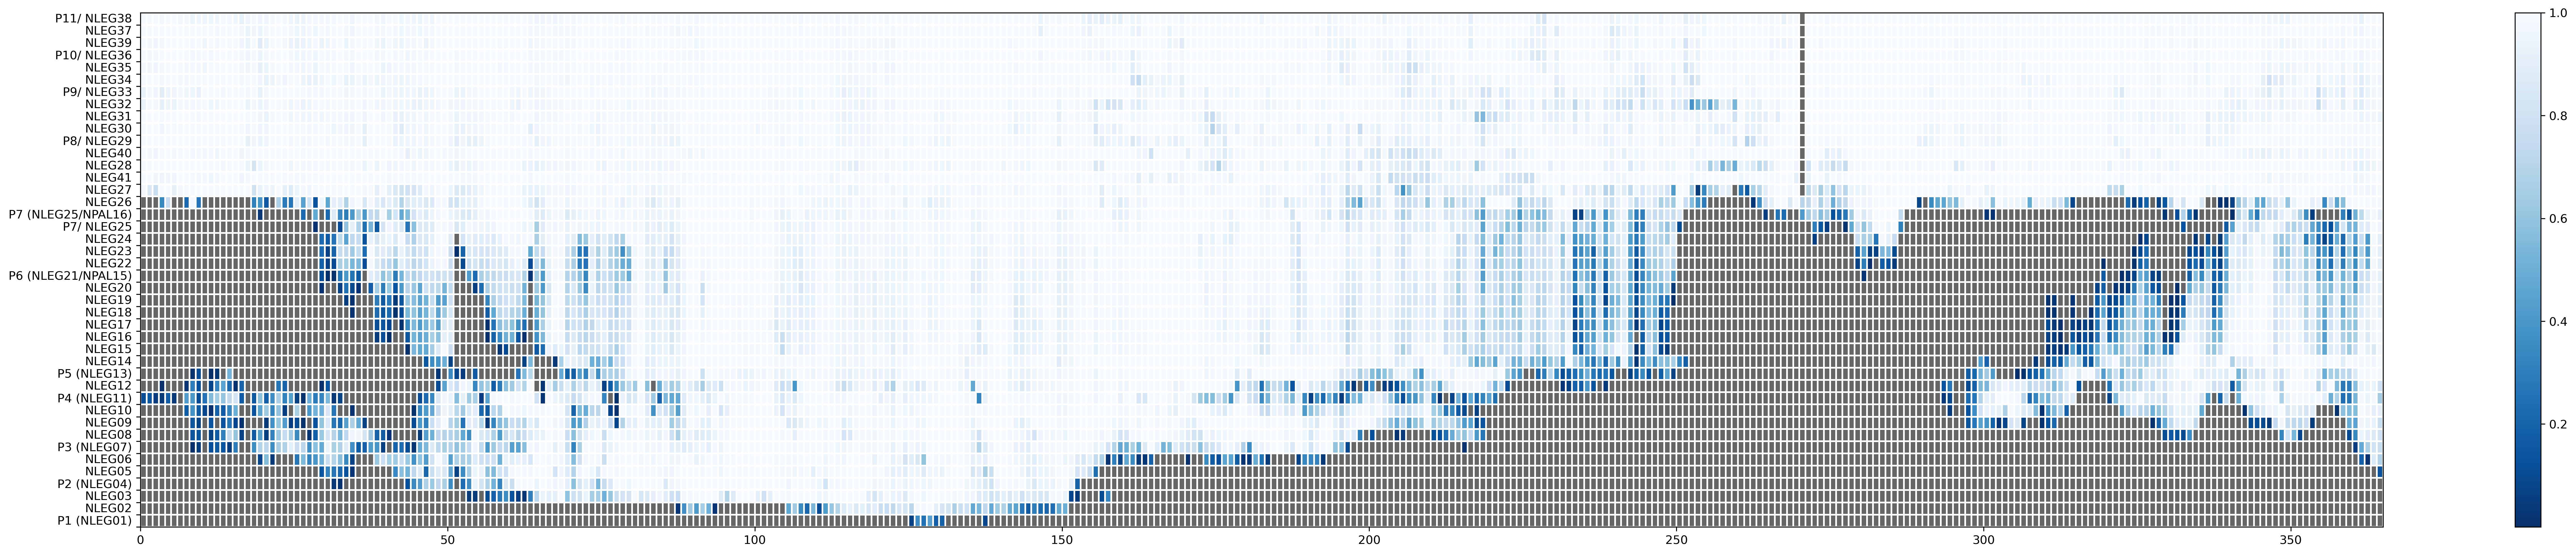

In [234]:
plot_df(plot_data["2017"], 2017)

1.0


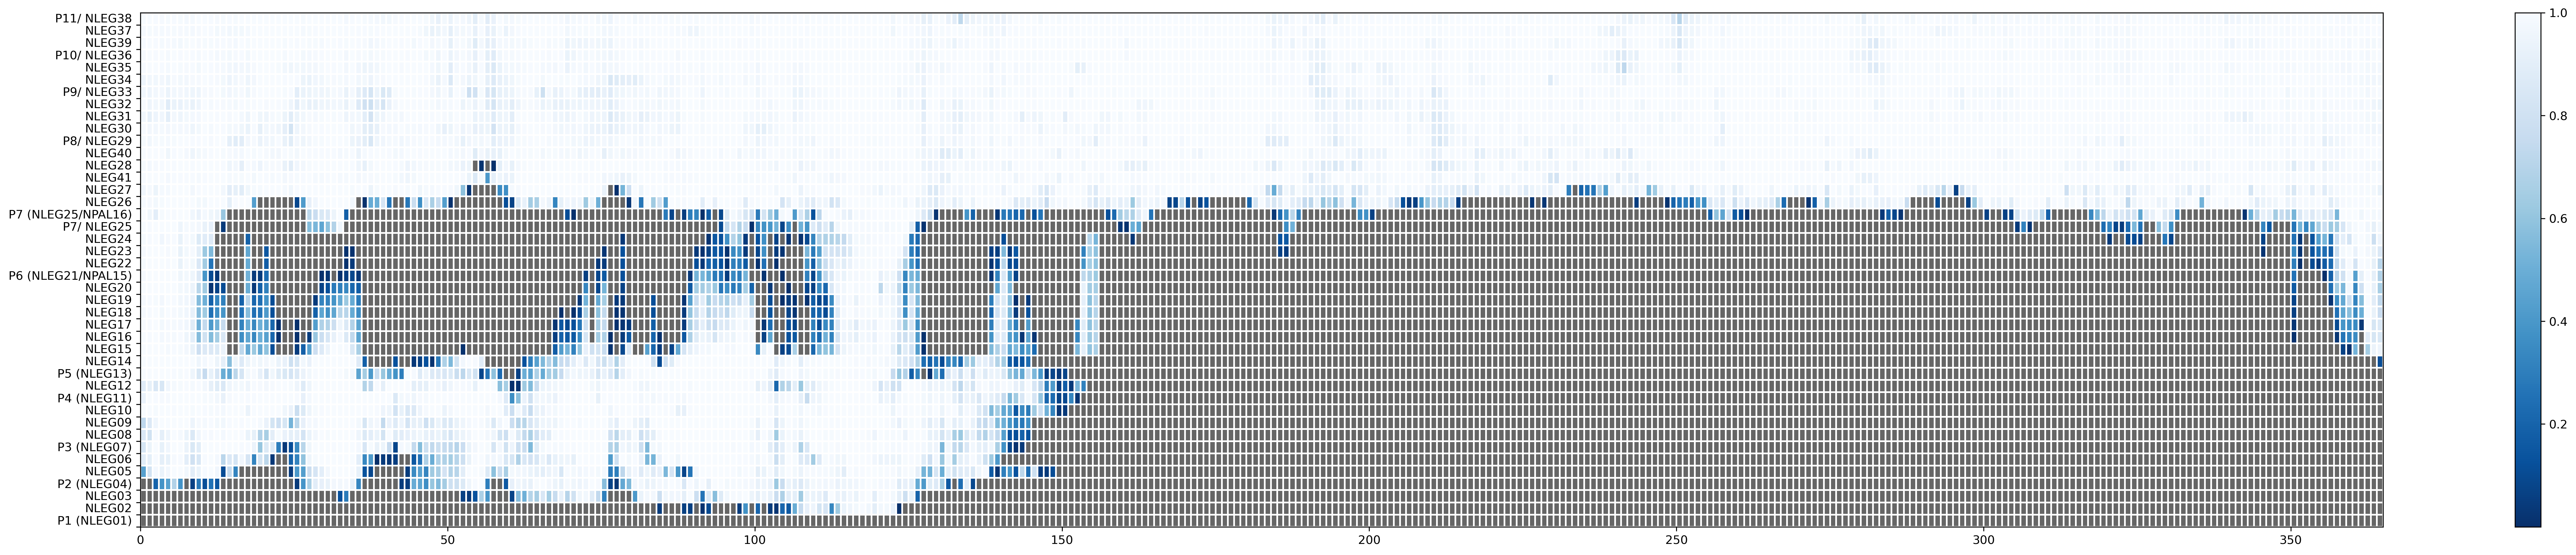

In [235]:
plot_df(plot_data["2018"], 2018)

1.0


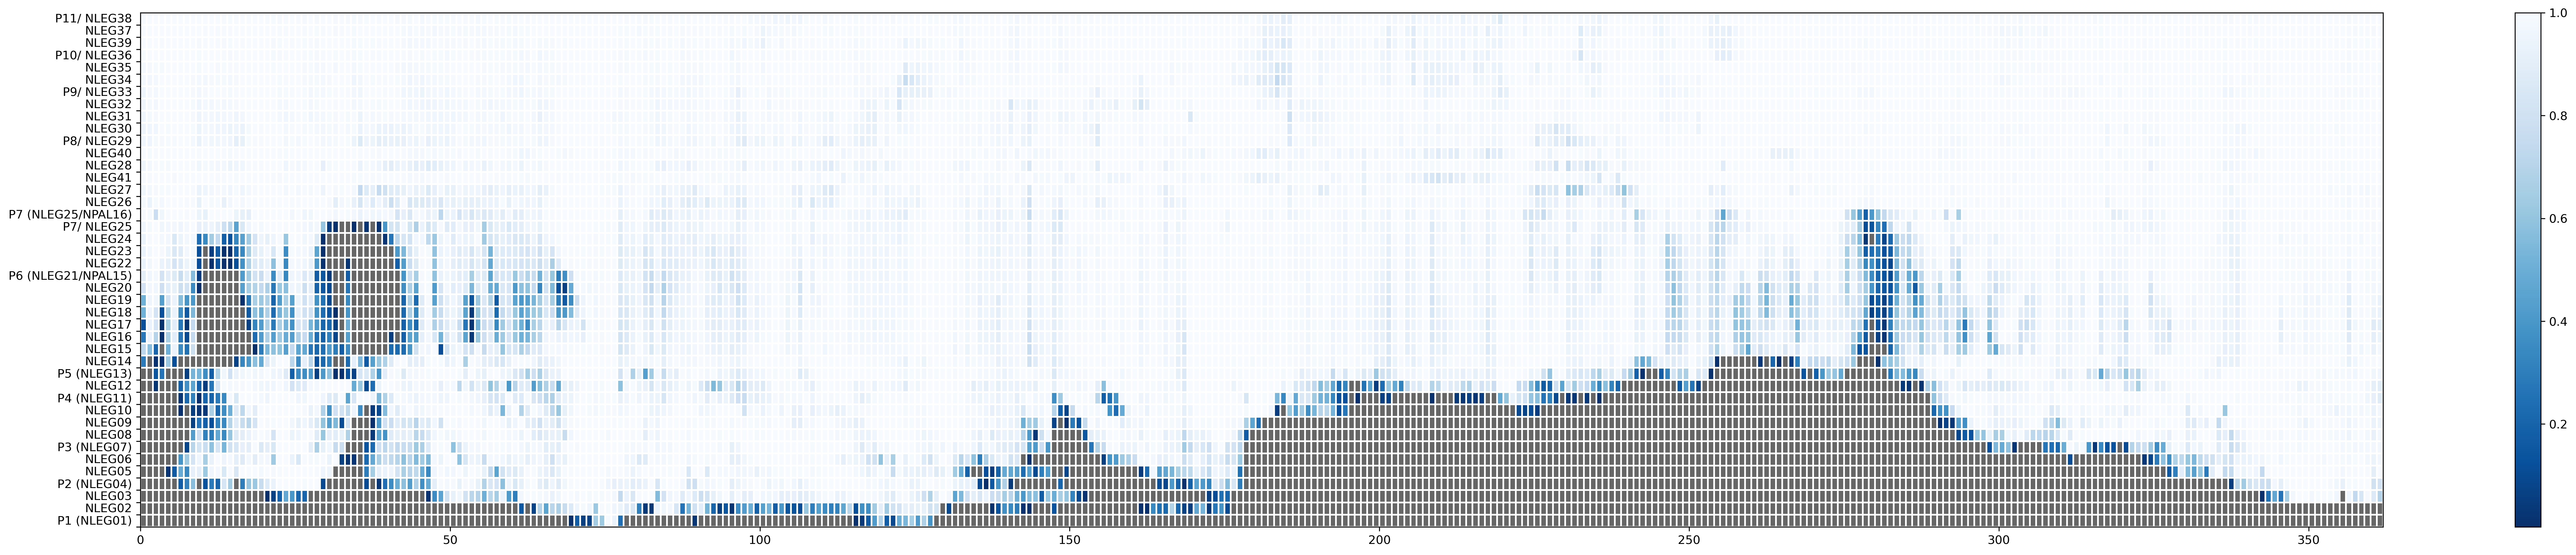

In [236]:
plot_df(plot_data["2019"], 2019)

1.0


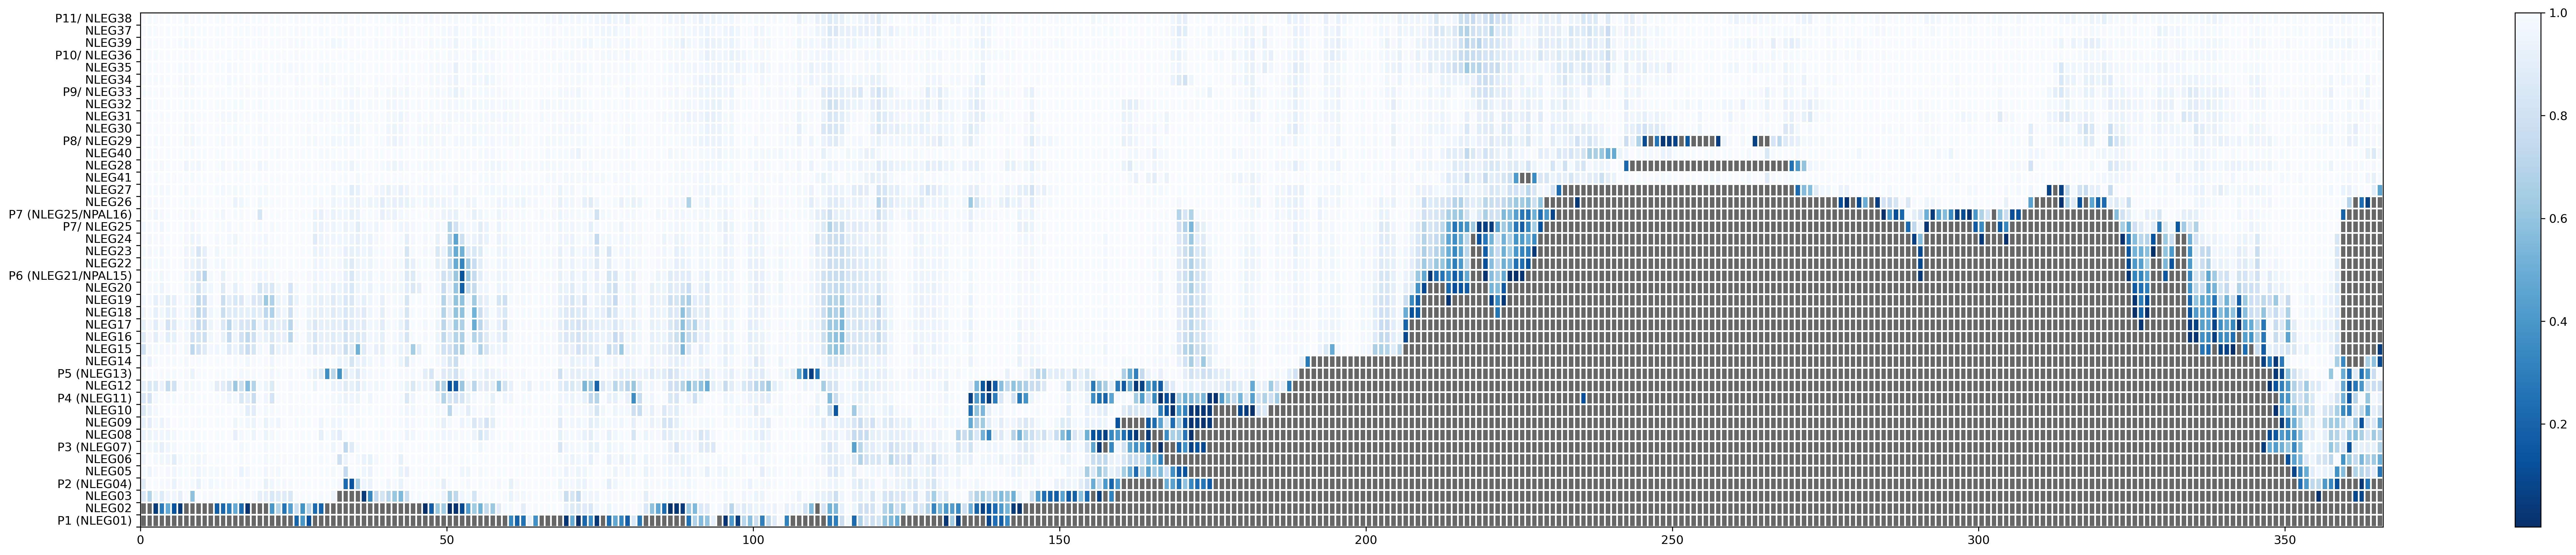

In [237]:
plot_df(plot_data["2020"], 2020)

1.0


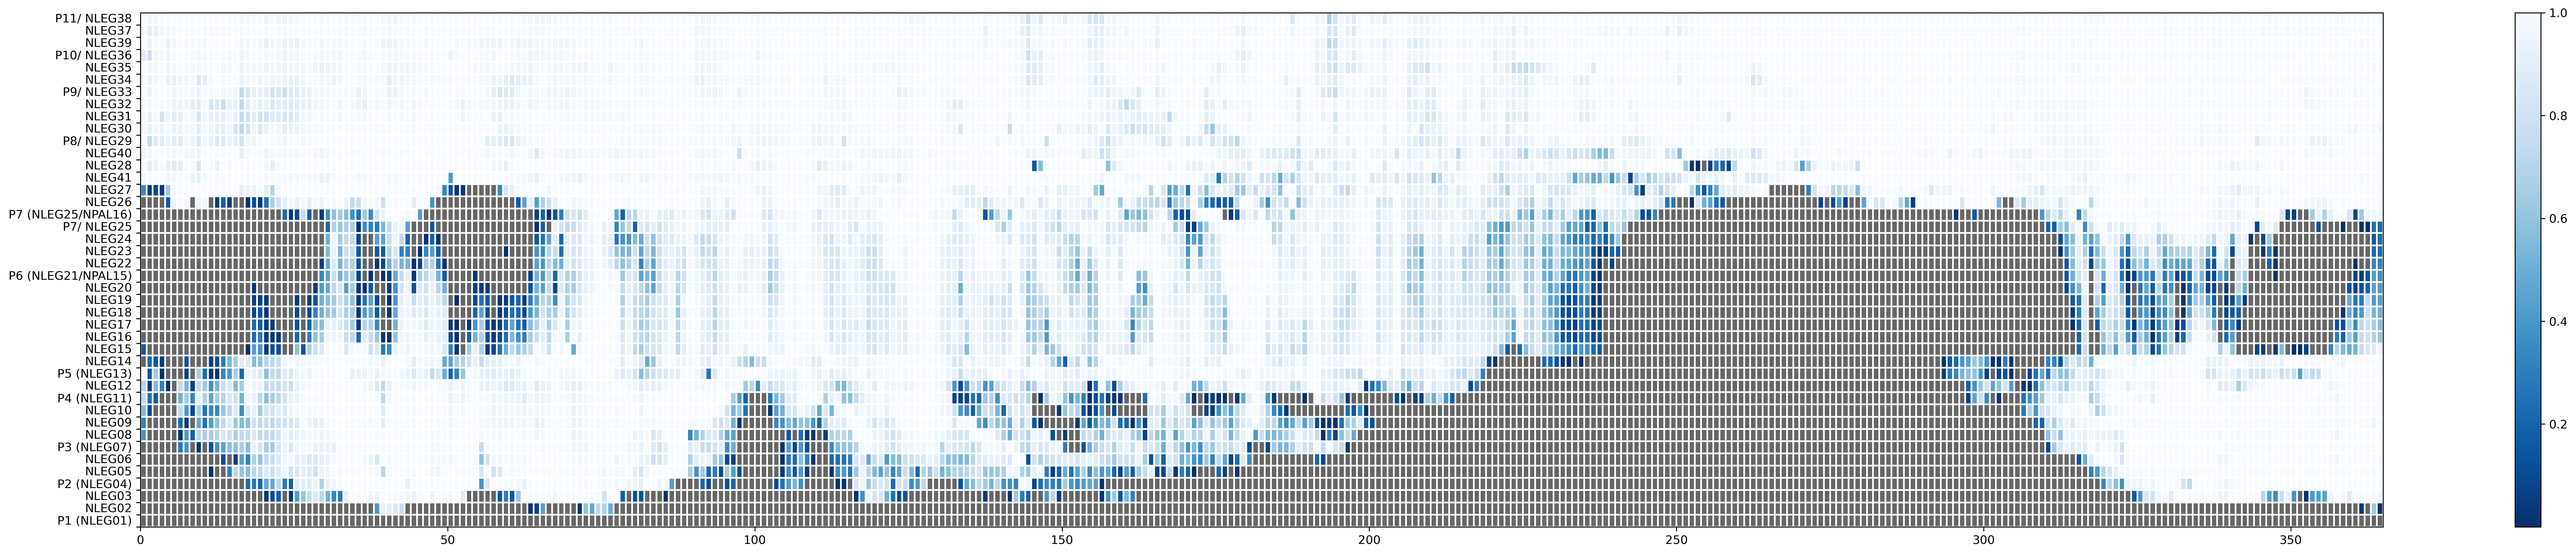

In [238]:
plot_df(plot_data["2021"], 2021)

In [244]:
#plot_data["2022"].to_csv("../../aen_2022_icecovered_days.csv")
plot_data["2021"].to_csv("../../aen_2021_icecovered_days.csv")
plot_data["2020"].to_csv("../../aen_2020_icecovered_days.csv")
plot_data["2019"].to_csv("../../aen_2019_icecovered_days.csv")
plot_data["2018"].to_csv("../../aen_2018_icecovered_days.csv")
plot_data["2017"].to_csv("../../aen_2017_icecovered_days.csv")



In [240]:
plot_data["2017"]

yearday                  1         2         3         4         5    \
station                                                                
P1 (NLEG01)         0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG02              0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG03              0.000000  0.000000  0.000000  0.000000  0.000000   
P2 (NLEG04)         0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG05              0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG06              0.000000  0.000000  0.000000  0.000000  0.000000   
P3 (NLEG07)         0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG08              0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG09              0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG10              0.000000  0.000000  0.000000  0.000000  0.000000   
P4 (NLEG11)         0.111144  0.149428  0.056032  0.039555  0.177316   
NLEG12              0.000000  0.000000  0.000000  0.010662  0.000000   
P5 (NLEG13)         0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG14              0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG15              0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG16              0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG17              0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG18              0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG19              0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG20              0.000000  0.000000  0.000000  0.000000  0.000000   
P6 (NLEG21/NPAL15)  0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG22              0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG23              0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG24              0.000000  0.000000  0.000000  0.000000  0.000000   
P7/ NLEG25          0.000000  0.000000  0.000000  0.000000  0.000000   
P7 (NLEG25/NPAL16)  0.000000  0.000000  0.000000  0.000000  0.000000   
NLEG26              0.000000  0.000000  0.000000  0.343458  0.747064   
NLEG27              0.967849  0.844386  0.771986  0.999313  1.000000   
NLEG41              1.000000  0.999854  0.958461  0.947742  0.954084   
NLEG28              0.983574  0.994346  1.000000  1.000000  1.000000   
NLEG40              0.990298  0.971541  0.952797  0.986288  0.996224   
P8/ NLEG29          1.000000  1.000000  1.000000  0.998737  1.000000   
NLEG30              0.991368  1.000000  0.996631  0.964598  0.987570   
NLEG31              0.999350  1.000000  1.000000  0.983120  0.993532   
NLEG32              0.935862  0.987104  0.976807  0.917960  0.941360   
P9/ NLEG33          0.924140  0.975375  0.955080  0.891001  0.942181   
NLEG34              0.987835  0.999209  0.996162  0.968403  0.986491   
NLEG35              0.972862  0.959745  0.964291  0.979963  0.989500   
P10/ NLEG36         0.991426  0.972620  0.973222  0.990540  0.996459   
NLEG39              0.995819  0.968650  0.961879  0.969757  0.997515   
NLEG37              0.998539  0.984464  0.995804  0.992631  1.000000   
P11/ NLEG38         1.000000  0.985800  0.989390  0.980001  0.985604   

yearday                  6         7         8         9         10   ...  \
station                                                               ...   
P1 (NLEG01)         0.000000  0.000000  0.000000  0.000000  0.000000  ...   
NLEG02              0.000000  0.000000  0.000000  0.000000  0.000000  ...   
NLEG03              0.000000  0.000000  0.000000  0.000000  0.000000  ...   
P2 (NLEG04)         0.000000  0.000000  0.000000  0.000000  0.000000  ...   
NLEG05              0.000000  0.000000  0.000000  0.000000  0.000000  ...   
NLEG06              0.000000  0.000000  0.000000  0.000000  0.000000  ...   
P3 (NLEG07)         0.000000  0.000000  0.000000  0.000200  0.045602  ...   
NLEG08              0.000000  0.000000  0.000000  0.151946  0.137944  ...   
NLEG09              0.000000  0.000000  0.000000  0.154899  0

In [241]:
## concatenate a lot of dataframes, I don't know how to do this all at once yet..

#16-17
#df1617 = pd.concat([dataframes["2016"], dataframes["2017"]]).groupby(by=['station', 'yearday']).sum()
#df1617.dropna(inplace = True)
#df1617 = df1617.reset_index(level=['station','yearday'])

df1617 = dataframes["2017"]

#add 2018
df1618 = pd.concat([df1617, dataframes["2018"]]).groupby(by=['station', 'yearday']).sum()
df1618.dropna(inplace = True)
df1618 = df1618.reset_index(level=['station','yearday'])
      
#add 2019
df1619 = pd.concat([df1618, dataframes["2019"]]).groupby(by=['station', 'yearday']).sum()
df1619.dropna(inplace = True)
df1619 = df1619.reset_index(level=['station','yearday'])

#add 2020
df1620 = pd.concat([df1619, dataframes["2020"]]).groupby(by=['station', 'yearday']).sum()
df1620.dropna(inplace = True)
df1620 = df1620.reset_index(level=['station','yearday'])

#add 2021
df1621 = pd.concat([df1620, dataframes["2021"]]).groupby(by=['station', 'yearday']).sum()
df1621.dropna(inplace = True)
df1621 = df1621.reset_index(level=['station','yearday'])

In [242]:
df1621_2= df1621.pivot(columns = "yearday", index="station", values = "ice")
df1621_2 = df1621_2.reindex(station_index)

5.0


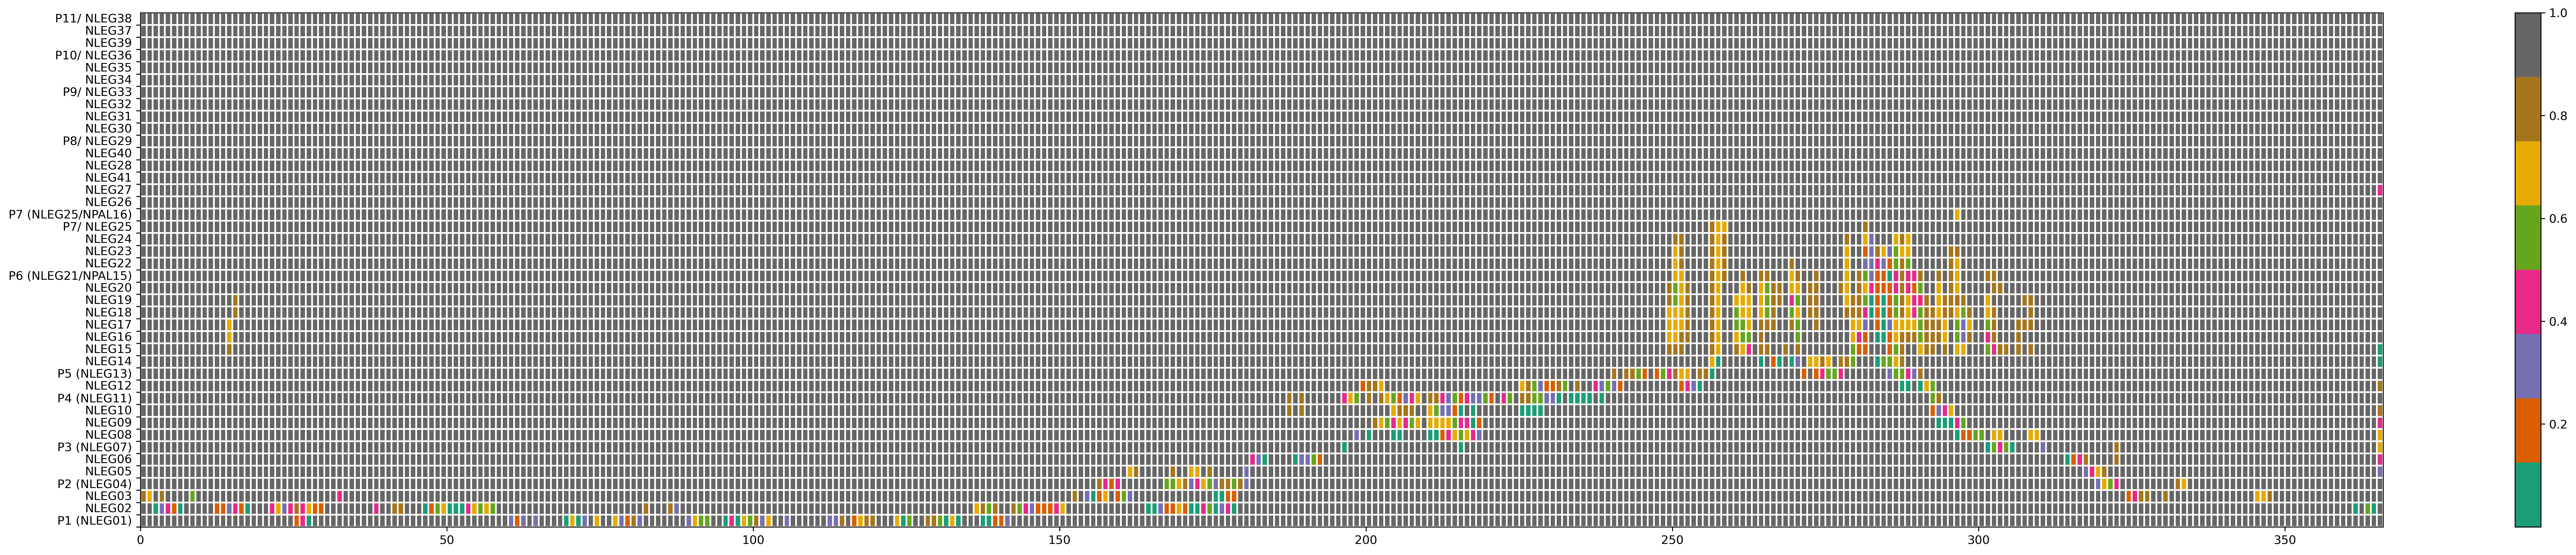

In [243]:
# choose colormaps here: https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html

plot_df(df1621_2, 20162021, "Dark2")

## Appendix - a place for putting PoC parts for now

### Ice station dates and locations from ship logs

Hard(er) stuff.

What we want in the end is:
- for each year, a set of days when the ship was at a station
- for each station and day, a logged ship position for sampling sea ice presence and concentration

This makes sure that statistics about ice cover are always computed for the correct sampling location.

We need to:
- for each year, create lists of when ships were at stations
- convert station dates to DOY
- set up an array where for each station name, we get a 1 or 0 for any DOY it was occupied
- this array needs to have the same shape as the ice cover 
- set up another list of station position on a given day, for spatial queries

#### Testing using the Q2 (May 2021) activity log

In [245]:
#read the Q2 activity log into a dataframe
q2_2021_dates = pd.read_csv("../mapdata/Activity_Log_Q2_2021704_FINAL.csv",
                      skiprows=2)

In [256]:
q2_2021_dates

eventDate eventTime stationName  decimalLatitude  decimalLongitude  \
0   29/04/21  20:53:18          P1          76.0001           31.2201   
1   30/04/21  16:41:35          P1          76.0004           31.2198   
2   01/05/21  13:32:17       NLEG2          76.4999           31.2184   
3   01/05/21  14:15:07       NLEG2          76.4999           31.2184   
4   01/05/21  14:16:46       NLEG2          76.4999           31.2184   
5   01/05/21  20:34:36       NLEG3          77.0001           34.0016   
6   02/05/21   0:44:33          P2          77.5021           34.0287   
7   02/05/21  22:46:31          P2          77.5004           34.0022   
8   03/05/21   4:36:51       NLEG5          77.9997           33.9993   
9   03/05/21   4:55:38       NLEG5          77.9997           33.9994   
10  03/05/21   5:02:10       NLEG5          77.9997           33.9994   
11  03/05/21   9:45:02       NLEG6          78.5002           33.9988   
12  03/05/21  13:28:26          P3          78.7499           33.9996   
13  04/05/21   0:16:06          P3          78.7325           33.9335   
14  04/05/21   3:56:23       NLEG8          79.0026           34.0365   
15  04/05/21   9:21:39       NLEG9          79.2514           33.9679   
16  04/05/21  10:27:17       NLEG9          79.2454           33.9849   
17  04/05/21  14:54:37      NLEG10          79.4992           34.0020   
18  04/05/21  18:19:50          P4          79.7476           33.9902   
19  06/05/21  20:21:42          P4          79.7610           34.0042   
20  07/05/21   0:13:19      NLEG12          79.9995           34.0021   
21  07/05/21  10:07:25          P5          80.5004           34.0051   
22  08/05/21   9:07:41          P5          80.5579           33.6227   
23  08/05/21  22:48:38      NLEG14          80.9993           33.9934   
24  08/05/21  23:09:26      NLEG14          81.0001           33.9936   
25  09/05/21   5:46:56      NLEG15          81.3094           31.3430   
26  09/05/21   7:05:50      NLEG16          81.3842           31.2503   
27  09/05/21   7:44:16      NLEG17          81.4115           31.2340   
28  09/05/21   8:20:05      NLEG18          81.4324           31.1469   
29  09/05/21   9:08:50      NLEG19          81.4593           31.0844   
30  09/05/21  12:16:22      NLEG20          81.5423           30.8415   
31  09/05/21  18:49:21          P6          81.5620           30.7457   
32  12/05/21   8:02:30          P6          81.5479           30.8488   
33  12/05/21   9:33:51      NLEG22          81.5892           30.7671   
34  12/05/21  14:01:17      NLEG23          81.6294           30.6536   
35  12/05/21  17:34:03      NLEG24          81.6845           30.5194   
36  12/05/21  20:28:15      NLEG24          81.6600           30.6454   
37  13/05/21  16:30:48      P7 ice          82.1472           29.1393   
38  16/05/21   5:29:02      P7 ice          81.7627           31.0886   
39  16/05/21  18:17:51      NLEG-A          81.6176           24.8862   
40  16/05/21  18:52:34      NLEG-A          81.6141           24.9027   
41  17/05/21   0:12:44      NLEG-B          81.3115           22.2097   
42  17/05/21   0:48:38      NLEG-B          81.3115           22.2097   
43  17/05/21  20:28:16      NLEG-C          81.3539           16.7124   
44  17/05/21  21:02:52      NLEG-C          81.3539           16.7125   
45  18/05/21  13:43:17      NLEG-D          80.4621           12.0618   
46  18/05/21  14:21:43      NLEG-D          80.4621           12.0618   

    bottomDepthInMeters start_date  end_date  end_time  endDecimalLatitude  \
0               326.260   29/04/21  29/04/21  21:11:35             76.0001   
1               325.800   30/04/21  01/05/21   9:59:03             76.0057   
2               312.300   01/05/21  01/05/21  14:08:38             76.4999   
3               312.265   01/05/21  01/05/21  14:15:18             76.4999   
4               312.260   01/05/21  01/05/21  14:47:03             76.4999   
5               156.970   01/0

In [247]:
#make a 1-366 series
yeardays = np.arange(1, 367, 1)

In [248]:
# get event days from the q2 dataframe
thedays = q2_2021_dates["eventDate"]

In [252]:
# see how many times we had events
len(thedays)

47

In [257]:
# get unique stations

thestations = q2_2021_dates.stationName.unique()
thestations

array(['P1', 'NLEG2', 'NLEG3', 'P2', 'NLEG5', 'NLEG6', 'P3', 'NLEG8',
       'NLEG9', 'NLEG10', 'P4', 'NLEG12', 'P5', 'NLEG14', 'NLEG15',
       'NLEG16', 'NLEG17', 'NLEG18', 'NLEG19', 'NLEG20', 'P6', 'NLEG22',
       'NLEG23', 'NLEG24', 'P7 ice', 'NLEG-A', 'NLEG-B', 'NLEG-C',
       'NLEG-D'], dtype=object)

array(['P1', 'NLEG2', 'NLEG3', 'P2', 'NLEG5', 'NLEG6', 'P3', 'NLEG8',
       'NLEG9', 'NLEG10', 'P4', 'NLEG12', 'P5', 'NLEG14', 'NLEG15',
       'NLEG16', 'NLEG17', 'NLEG18', 'NLEG19', 'NLEG20', 'P6', 'NLEG22',
       'NLEG23', 'NLEG24', 'P7 ice', 'NLEG-A', 'NLEG-B', 'NLEG-C',
       'NLEG-D'], dtype=object)

each event has a start and end date, a start and end position.

We need:
- for each day of year on which and event happened, a median station position
- a buffer around each of those positions

To do that:
- get event name
- get event start date and convert to DoY
- get event end date and convert to DoY
- get event start position and transform to North Polar Stereo
- get event end position and transform to North Polar Stereo
- assign the mean position for the whole event to the event position for grid plotting. 
- for plotting 'ship on station' days, add a 'ship present' flag for every day of the event

In [14]:
#create a new dataframe to hold ship present/absent days
#q2_2021 = pd.DataFrame(columns = list(yeardays))

In [15]:
q2_2021.insert(0, "stationName", station_index )

In [16]:
q2_2021[0:10]

stationName    1    2    3    4    5    6    7    8    9  ...  357  358  \
0  P1 (NLEG01)  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1       NLEG02  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2       NLEG03  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3  P2 (NLEG04)  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4       NLEG05  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5       NLEG06  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6  P3 (NLEG07)  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
7       NLEG08  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
8       NLEG09  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
9       NLEG10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

   359  360  361  362  363  364  365  366  
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
9  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[10 rows x 367 columns]

In [17]:
station_names = q2_2021_dates["stationName"]

In [18]:
len(station_names)

47

In [19]:
days_of_year = []
# we need to end up here with a list of occupied year days for each station,
# eg nleg24: 0-366

for thisday in q2_2021_dates["eventDate"]:

    ### convert the date into a day of year
    #print(thisday)
    theday = datetime.datetime.strptime(thisday, "%d/%m/%y")
    period = pd.Period(theday, freq='D')
    days_of_year.append(period.day_of_year)


In [20]:
the_station_days = pd.DataFrame({"station_name": q2_2021_dates["stationName"],
                               "day_of_year": days_of_year})

In [ ]:
the_station_days.loc[the_station_days["station_name"] == "P1"]

In [ ]:
the_station_days

In [22]:
q2_2021.loc[q2_2021["stationName"].str.contains("P1 ")][350].values

array([nan], dtype=object)

In [23]:
that = q2_2021.loc[q2_2021["stationName"].str.contains("P1 ")][350]

In [24]:
presence = []
for stationday in the_station_days.loc[the_station_days["station_name"] == "P1"].values:
    for theday in yeardays:
        if stationday[1] == theday:
            print(theday)
            this = q2_2021.loc[q2_2021["stationName"].str.contains("P1 ")][theday]
            print(this)
            
            this = 1
        else:
            this = q2_2021.loc[q2_2021["stationName"].str.contains("")][theday]
            this = 0
 
            #presence.append(0)
    

119
0    NaN
Name: 119, dtype: object
120
0    NaN
Name: 120, dtype: object


In [25]:
q2_2021[0:5]

stationName    1    2    3    4    5    6    7    8    9  ...  357  358  \
0  P1 (NLEG01)  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1       NLEG02  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2       NLEG03  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3  P2 (NLEG04)  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4       NLEG05  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

   359  360  361  362  363  364  365  366  
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 367 columns]

### caution, broken parts exposed here!

In [25]:
q2_2021["station"] = q2_2021_dates["stationName"].values
q2_2021["yearday"] = days_of_year
q2_2021["presence"] = np.ones(len(days_of_year))

ValueError: Length of values (47) does not match length of index (42)

In [ ]:
q2_2021.dropna(inplace = True)
q2_21_2 = q2_2021.pivot(columns = "yearday", index="station", values = "presence")
q2_21_2 = q2_21_2.reindex(stationIndex)

In [ ]:
station21, yearday21 = np.mgrid[:q2_21_2.shape[0]+1, :q2_21_2.shape[1]+1]

fig, ax = plt.subplots(figsize=(30, 10))
#ax.set_aspect("equal")
plt.pcolormesh(yearday21, station21, q2_21_2.values, cmap="Reds", edgecolor="w", vmin=0, vmax=1)
plt.xlim(0, q2_21_2.shape[1])
#plt.yticks(tw17_2["station"])
ax.set_yticks(range(len(q2_21_2.index)))
ax.set_yticklabels(q2_21_2.index, va='bottom')
